In [1]:
#Cell 1: Import and global variables

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os, re, random
import shutil

RES_LIST = ["192x192","224x224","331x331","512x512"]
NUM_CLASSES = 104
BATCH_SIZE = 32

E0000 00:00:1758450287.033656      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [2]:
#Cell 2: data preprocess functions

# TFRecord parsing - to extract TFREC files and preprocess data
def parse_example(example_proto, target_size=(224,224), with_label=True):
    feature_description = {
        "id": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    if with_label:
        feature_description["class"] = tf.io.FixedLenFeature([], tf.int64)

    features = tf.io.parse_single_example(example_proto, feature_description)

    # Decode + preprocess image
    image = tf.io.decode_jpeg(features["image"], channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    
    if with_label:
        label = features["class"]
        label = tf.one_hot(label, depth=NUM_CLASSES) #needed for label smoothing
        return image, label
    else:
        return image, features["id"]


# Dataset loader
def make_ds(tfrecord_dir, target_size=(224,224), batch_size=BATCH_SIZE, with_label=True):
    files = tf.io.gfile.glob(tfrecord_dir + "/*.tfrec")
    if not files:
        raise FileNotFoundError(f"No TFRecord files found in {tfrecord_dir}")

    ds = tf.data.TFRecordDataset(files)
    ds = ds.map(
        lambda x: parse_example(x, target_size=target_size, with_label=with_label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return ds

# Count parsed data from the 4 folders - needed to define steps_per_epoch and validation_steps
def count_from_filenames(path):
    total = 0
    for fname in os.listdir(path):
        m = re.search(r"-(\d+)\.tfrec$", fname)
        if m:
            total += int(m.group(1))
    return total

# Data augmentation only for low samples classes
def augment_if_rare(x, y):
    class_id = tf.argmax(y, axis=-1) # convert one-hot label -> integer index
    is_rare = tf.reduce_any(tf.equal(class_id, rare_classes))    
    x = tf.cond(
        is_rare,
        lambda: rare_augmentation(x, training=True),
        lambda: x
        )
    return x, y

In [3]:
#Cell 3: Utility functions

# Show one image from a train set
def show_sample(ds, count): #heavy
    rand = random.randrange(count)
    try:
        example = ds.unbatch().skip(rand).take(1)
        for img, lbl in example:
            plt.figure()
            plt.imshow(img.numpy()/255.0)
            # Convert one-hot to integer
            if len(lbl.shape) > 0 and lbl.shape[-1] > 1:
                class_id = int(tf.argmax(lbl).numpy())
            else:
                class_id = int(lbl.numpy()[0] if len(lbl.shape) > 0 else lbl.numpy())
                
            plt.title(f"Label/ID: {class_id}")
            plt.axis("off")
            plt.show()
    except StopIteration:
        print(f"Train dataset empty")

# Count samples for class to setup classes weights
def samples_counter(train_ds,NUM_CLASSES): #very heavy
    # unbatch the dataset
    ds_unbatched = train_ds.unbatch().take(51012)

    # extract labels and sum
    counts = tf.zeros([NUM_CLASSES], dtype=tf.int32)

    for _, lbl in ds_unbatched:
        # Convert one-hot to integer class
        class_id = int(tf.argmax(lbl).numpy())
        counts = tf.tensor_scatter_nd_add(counts, indices=[[class_id]], updates=[1])

    counts_np = counts.numpy()
    
    print("Total samples:", counts_np.sum())
    print("Class counts:", counts_np)

    plt.figure(figsize=(12,4))
    plt.bar(range(NUM_CLASSES), counts_np, color="skyblue")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Class Distribution")
    plt.show()

    return counts_np

# Save one samples for class to show it in prediction - datset have only integer labels
def save_samples(ds):
    save_dir = "sample_images"
    os.makedirs(save_dir, exist_ok=True)
    
    saved_labels = set()
    
    for image, label in ds.unbatch():
        label_val = int(tf.argmax(label).numpy())
        if label_val not in saved_labels:
            saved_labels.add(label_val)
            img_np = image.numpy().astype("uint8") # convert tensor to numpy
            plt.imsave(os.path.join(save_dir, f"class_{label_val}.png"), img_np)
        if len(saved_labels) == NUM_CLASSES:  
            break
    # Zip the folder to make it downloadable from kaggle
    shutil.make_archive("sample_images", 'zip', "sample_images")

# Plot training accuracy 
def plot_training(history_head, history_finetune):
    plt.figure(figsize=(10, 6))
    
    plt.plot(history_head.history["accuracy"], "o-", label="Head Train Acc", alpha=0.8)
    plt.plot(history_head.history["val_accuracy"], "o--", label="Head Val Acc", alpha=0.8)
    
    plt.plot(history_finetune.history["accuracy"], "s-", label="Finetune Train Acc", alpha=0.8)
    plt.plot(history_finetune.history["val_accuracy"], "s--", label="Finetune Val Acc", alpha=0.8)

    plt.title("Training vs Validation Accuracy (Head & Fine-tuning)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

I0000 00:00:1758450307.920152      10 service.cc:148] XLA service 0x580a5d749bb0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758450307.920191      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1758450307.920195      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1758450307.920197      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1758450307.920199      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1758450307.920201      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1758450307.920202      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1758450307.920204      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1758450307.920205      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


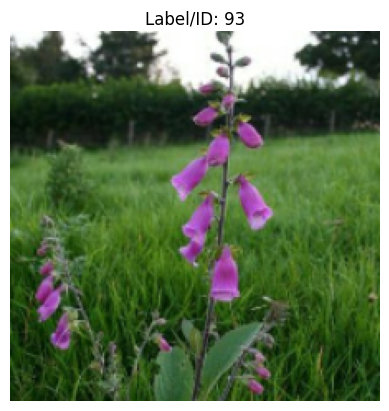

Total samples: 51012
Class counts: [1088  104   80   84 2812  348   72  420  348  336  544  172  368 1052
  908   84  220  200  360  104   76  384  192   76  340  332   84  136
  476  436  420   96   92   80   72  144  228  104   76  292  256  384
  252  440   72  688  500 1044 1688 2252  804  420  460 1840  148  232
  356  252  144  232  108  116  372  112  220  132   84 3128 1040  376
  416  548  668 1840  500 1224  476  556  344  472  612  404  536  448
  124  116  480  584  384  184  424  444   96  556  524  508  400  164
  136   96  124  100 1560 2972]


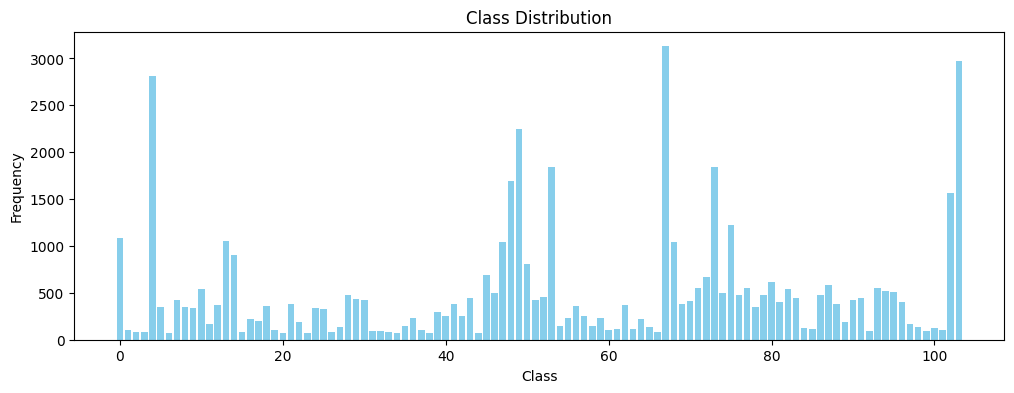

Train size: 51012
Val size: 14848


In [4]:
#Cell 4: Data setup and visualization

train_count,val_count,test_count = int(0),int(0),int(0)
for res in RES_LIST:
    train_count += count_from_filenames(f"/kaggle/input/dataset-flowers/dataset/{res}/train")
    val_count   += count_from_filenames(f"/kaggle/input/dataset-flowers/dataset/{res}/val")
    test_count   += count_from_filenames(f"/kaggle/input/dataset-flowers/dataset/{res}/val")

# Need to use make_ds on every folder with different shape
train = [make_ds(
    f"/kaggle/input/dataset-flowers/dataset/{res}/train",
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    with_label=True
    ) for res in RES_LIST]
train_ds = train[0]
for ds in train[1:]:
    train_ds = train_ds.concatenate(ds)

train_ds = train_ds.shuffle(10000).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val = [make_ds(
    f"/kaggle/input/dataset-flowers/dataset/{res}/val",
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    with_label=True
) for res in RES_LIST]
val_ds = val[0]
for ds in val[1:]:
    val_ds = val_ds.concatenate(ds)

val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

show_sample(train_ds, train_count) #heavy
counts = samples_counter(train_ds,NUM_CLASSES) #very heavy, used to obtain counts

print("Train size:", train_count)
print("Val size:", val_count)

In [5]:
#Cell 5: Class weights and rare data augmentation

# obtained by using samples_counter(train_ds), uncomment if don't want to use the function
"""
counts = np.array([ 1088, 104, 80, 84, 2812, 348, 72, 420, 348, 336, 544, 172, 368, 1052,
                    908, 84, 220, 200, 360, 104, 76, 384, 192, 76, 340, 332, 84, 136, 476,
                    436, 420, 96, 92, 80, 72, 144, 228, 104, 76, 292, 256, 384, 252, 440,
                    72, 688, 500, 1044, 1688, 2252, 804, 420, 460, 1840, 148, 232, 356,
                    252, 144, 232, 108, 116, 372, 112, 220, 132, 84, 3128, 1040, 376, 416,
                    548, 668, 1840, 500, 1224, 476, 556, 344, 472, 612, 404, 536, 448,
                    124, 116, 480, 584, 384, 184, 424, 444, 96, 556, 524, 508, 400, 164,
                    136, 96, 124, 100, 1560, 2972
                    ])  
""" 

total = np.sum(counts)
class_weights = {i: total/(len(counts) * c) for i, c in enumerate(counts)} #obtaining class weights

threshold = 500  # samples threshold for data augmentation
# Define augmentation only for rare classes
rare_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

rare_classes = tf.constant([i for i, c in enumerate(counts) if c < threshold], dtype=tf.int64)

# Apply only rare-class augmentation
train_ds_aug = (
    train_ds
    .unbatch()
    .map(augment_if_rare, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(10000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
#Cell 6: TPU device setup 

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    print("✅ TPU detected:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    tpu = True
except Exception as e:
    tpu = None
    print(e)
    print("❌ No active TPU")
    strategy = tf.distribute.get_strategy()

if tpu:
    print("✅ Using strategy:", strategy)
    
    print("Devices:", tf.config.list_logical_devices())
    print("Logical devices:", tf.config.list_logical_devices())

✅ TPU detected: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/

In [7]:
#Cell 7: Model definition and summary

steps_per_epoch = train_count // BATCH_SIZE #needed for train - dataset need to be repeated but epochs need to have an end
validation_steps = val_count // BATCH_SIZE

loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.1
) #using categorical - onehotencoded labels needed to do labels smoothing

with strategy.scope():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = inputs
    base_model = tf.keras.applications.EfficientNetV2B3(
    input_shape=(224, 224, 3),   # EfficientNetV2B3 default
    include_top=False,
    weights="imagenet"
    )

    base_model.trainable = False  # freeze backbone for transfer learning

    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=loss,
        metrics=["accuracy"]
    )

model.summary()

I0000 00:00:1758450357.077382      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 104)            │       159,848 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,090,470 (49.94 MB)

 Trainable params: 159,848 (624.41 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [8]:
#Cell 8: Head train

early_stop = EarlyStopping(
    monitor="val_loss",       
    patience=3,             
    restore_best_weights=True
)

with strategy.scope():
    base_model.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=loss,
        metrics=["accuracy"]
    )

history_head = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stop]
)

Epoch 1/30


I0000 00:00:1758450394.848608      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16069770664222301158
I0000 00:00:1758450396.684746    1158 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2837646869966070381), session_name()
I0000 00:00:1758450454.180804    1158 tpu_compile_op_common.cc:245] Compilation of 2837646869966070381 with session name  took 57.496011777s and succeeded
I0000 00:00:1758450454.315387    1158 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2837646869966070381), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16069770664222301158", property.function_library_fingerprint = 14285387860982026708, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5562 - loss: 2.6869

I0000 00:00:1758450552.741604      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:12339807115470352495
I0000 00:00:1758450553.824293    1135 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13983203620137539793), session_name()
I0000 00:00:1758450560.785113    1135 tpu_compile_op_common.cc:245] Compilation of 13983203620137539793 with session name  took 6.960772871s and succeeded
I0000 00:00:1758450560.810360    1135 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13983203620137539793), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_12339807115470352495", property.function_library_fingerprint = 13998300700516315073, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 268s 127ms/step - accuracy: 0.5563 - loss: 2.6865 - val_accuracy: 0.7819 - val_loss: 1.6479
Epoch 2/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 243s 152ms/step - accuracy: 0.8159 - loss: 1.4052 - val_accuracy: 0.8207 - val_loss: 1.5397
Epoch 3/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 246s 155ms/step - accuracy: 0.8429 - loss: 1.3980 - val_accuracy: 0.8198 - val_loss: 1.5194
Epoch 4/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 266s 167ms/step - accuracy: 0.8490 - loss: 1.3301 - val_accuracy: 0.8343 - val_loss: 1.4923
Epoch 5/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 275s 173ms/step - accuracy: 0.8645 - loss: 1.3323 - val_accuracy: 0.8433 - val_loss: 1.4693
Epoch 6/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 244s 153ms/step - accuracy: 0.8656 - loss: 1.2861 - val_accuracy: 0.8339 - val_loss: 1.4897
Epoch 7/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 252s 158ms/step - accuracy: 0.8758 - loss: 1.2913 - val_accuracy: 0.8365 - val_loss: 1.4809
Epoch 8/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 270s 170ms/step - accuracy: 0.8

In [9]:
#Cell 9: Fine tuning

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1),
    ModelCheckpoint("best_finetuned.h5", monitor="val_loss", save_best_only=True)
]

with strategy.scope():
    base_model.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR
        loss=loss,
        metrics=["accuracy"]
    )

history_finetune = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks
)

model.save("/kaggle/working/model.keras") #save model to use on django app to predict

Epoch 1/50


I0000 00:00:1758454259.863821      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14114545807508175333
I0000 00:00:1758454265.732473    1113 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1102405978658841459), session_name()
I0000 00:00:1758454368.254305    1113 tpu_compile_op_common.cc:245] Compilation of 1102405978658841459 with session name  took 1m42.52179471s and succeeded
I0000 00:00:1758454368.432323    1113 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1102405978658841459), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_14114545807508175333", property.function_library_fingerprint = 3286982928865901181, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2627 - loss: 3.5895

I0000 00:00:1758454538.506318      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:12481180825471616256
I0000 00:00:1758454539.736703    1128 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3932990165116599771), session_name()
I0000 00:00:1758454546.410644    1128 tpu_compile_op_common.cc:245] Compilation of 3932990165116599771 with session name  took 6.673905318s and succeeded
I0000 00:00:1758454546.436482    1128 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3932990165116599771), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_12481180825471616256", property.function_library_fingerprint = 4139536323724323804, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 434s 193ms/step - accuracy: 0.2627 - loss: 3.5892 - val_accuracy: 0.6641 - val_loss: 2.0623 - learning_rate: 1.0000e-05
Epoch 2/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5197 - loss: 2.3085

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 307s 193ms/step - accuracy: 0.5197 - loss: 2.3085 - val_accuracy: 0.7289 - val_loss: 1.8007 - learning_rate: 1.0000e-05
Epoch 3/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6360 - loss: 1.8614

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 304s 191ms/step - accuracy: 0.6360 - loss: 1.8614 - val_accuracy: 0.7609 - val_loss: 1.6998 - learning_rate: 1.0000e-05
Epoch 4/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6532 - loss: 1.7752

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 314s 197ms/step - accuracy: 0.6532 - loss: 1.7752 - val_accuracy: 0.7887 - val_loss: 1.6278 - learning_rate: 1.0000e-05
Epoch 5/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7062 - loss: 1.5508

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 313s 196ms/step - accuracy: 0.7062 - loss: 1.5508 - val_accuracy: 0.8040 - val_loss: 1.5750 - learning_rate: 1.0000e-05
Epoch 6/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7587 - loss: 1.4632

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 306s 192ms/step - accuracy: 0.7587 - loss: 1.4633 - val_accuracy: 0.8237 - val_loss: 1.5471 - learning_rate: 1.0000e-05
Epoch 7/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7640 - loss: 1.4543

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 321s 201ms/step - accuracy: 0.7640 - loss: 1.4542 - val_accuracy: 0.8349 - val_loss: 1.5207 - learning_rate: 1.0000e-05
Epoch 8/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7781 - loss: 1.3992

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 315s 198ms/step - accuracy: 0.7781 - loss: 1.3991 - val_accuracy: 0.8419 - val_loss: 1.4869 - learning_rate: 1.0000e-05
Epoch 9/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8015 - loss: 1.3728

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 326s 204ms/step - accuracy: 0.8015 - loss: 1.3728 - val_accuracy: 0.8458 - val_loss: 1.4613 - learning_rate: 1.0000e-05
Epoch 10/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8319 - loss: 1.3253

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 329s 207ms/step - accuracy: 0.8319 - loss: 1.3253 - val_accuracy: 0.8494 - val_loss: 1.4576 - learning_rate: 1.0000e-05
Epoch 11/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8336 - loss: 1.2710

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 338s 212ms/step - accuracy: 0.8336 - loss: 1.2710 - val_accuracy: 0.8564 - val_loss: 1.4382 - learning_rate: 1.0000e-05
Epoch 12/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8448 - loss: 1.2623

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 330s 207ms/step - accuracy: 0.8448 - loss: 1.2623 - val_accuracy: 0.8660 - val_loss: 1.4194 - learning_rate: 1.0000e-05
Epoch 13/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 334s 209ms/step - accuracy: 0.8641 - loss: 1.2265 - val_accuracy: 0.8640 - val_loss: 1.4237 - learning_rate: 1.0000e-05
Epoch 14/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8711 - loss: 1.2107

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 340s 213ms/step - accuracy: 0.8711 - loss: 1.2107 - val_accuracy: 0.8682 - val_loss: 1.4128 - learning_rate: 1.0000e-05
Epoch 15/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8673 - loss: 1.2160

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 353s 222ms/step - accuracy: 0.8673 - loss: 1.2160 - val_accuracy: 0.8726 - val_loss: 1.3934 - learning_rate: 1.0000e-05
Epoch 16/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8761 - loss: 1.2245

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 356s 223ms/step - accuracy: 0.8761 - loss: 1.2245 - val_accuracy: 0.8815 - val_loss: 1.3775 - learning_rate: 1.0000e-05
Epoch 17/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8981 - loss: 1.1338

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 353s 221ms/step - accuracy: 0.8981 - loss: 1.1338 - val_accuracy: 0.8790 - val_loss: 1.3712 - learning_rate: 1.0000e-05
Epoch 18/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8967 - loss: 1.1301

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 360s 226ms/step - accuracy: 0.8967 - loss: 1.1301 - val_accuracy: 0.8811 - val_loss: 1.3516 - learning_rate: 1.0000e-05
Epoch 19/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8980 - loss: 1.1432

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 363s 228ms/step - accuracy: 0.8980 - loss: 1.1432 - val_accuracy: 0.8854 - val_loss: 1.3438 - learning_rate: 1.0000e-05
Epoch 20/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9156 - loss: 1.1060

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 358s 224ms/step - accuracy: 0.9156 - loss: 1.1060 - val_accuracy: 0.8850 - val_loss: 1.3398 - learning_rate: 1.0000e-05
Epoch 21/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9197 - loss: 1.1324

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 365s 229ms/step - accuracy: 0.9197 - loss: 1.1324 - val_accuracy: 0.8877 - val_loss: 1.3210 - learning_rate: 1.0000e-05
Epoch 22/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 361s 227ms/step - accuracy: 0.9221 - loss: 1.0834 - val_accuracy: 0.8885 - val_loss: 1.3315 - learning_rate: 1.0000e-05
Epoch 23/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9295 - loss: 1.0680

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 368s 231ms/step - accuracy: 0.9295 - loss: 1.0680 - val_accuracy: 0.8914 - val_loss: 1.3178 - learning_rate: 1.0000e-05
Epoch 24/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9276 - loss: 1.0948

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 369s 231ms/step - accuracy: 0.9276 - loss: 1.0948 - val_accuracy: 0.8931 - val_loss: 1.3114 - learning_rate: 1.0000e-05
Epoch 25/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9288 - loss: 1.0817

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 363s 228ms/step - accuracy: 0.9288 - loss: 1.0817 - val_accuracy: 0.8935 - val_loss: 1.3069 - learning_rate: 1.0000e-05
Epoch 26/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9328 - loss: 1.0219

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 358s 225ms/step - accuracy: 0.9328 - loss: 1.0220 - val_accuracy: 0.8972 - val_loss: 1.2919 - learning_rate: 1.0000e-05
Epoch 27/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9341 - loss: 1.0694

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 357s 224ms/step - accuracy: 0.9341 - loss: 1.0693 - val_accuracy: 0.8962 - val_loss: 1.2861 - learning_rate: 1.0000e-05
Epoch 28/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 358s 224ms/step - accuracy: 0.9472 - loss: 1.0138 - val_accuracy: 0.8957 - val_loss: 1.2893 - learning_rate: 1.0000e-05
Epoch 29/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9519 - loss: 0.9927

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 364s 229ms/step - accuracy: 0.9519 - loss: 0.9927 - val_accuracy: 0.9019 - val_loss: 1.2680 - learning_rate: 1.0000e-05
Epoch 30/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 357s 224ms/step - accuracy: 0.9471 - loss: 1.0030 - val_accuracy: 0.9013 - val_loss: 1.2741 - learning_rate: 1.0000e-05
Epoch 31/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9572 - loss: 0.9978

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 362s 227ms/step - accuracy: 0.9572 - loss: 0.9978 - val_accuracy: 0.9001 - val_loss: 1.2677 - learning_rate: 1.0000e-05
Epoch 32/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9586 - loss: 0.9899

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 357s 224ms/step - accuracy: 0.9586 - loss: 0.9899 - val_accuracy: 0.9009 - val_loss: 1.2636 - learning_rate: 1.0000e-05
Epoch 33/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9589 - loss: 0.9997

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 370s 232ms/step - accuracy: 0.9589 - loss: 0.9997 - val_accuracy: 0.9034 - val_loss: 1.2592 - learning_rate: 1.0000e-05
Epoch 34/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9594 - loss: 0.9950

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 352s 221ms/step - accuracy: 0.9594 - loss: 0.9949 - val_accuracy: 0.9054 - val_loss: 1.2532 - learning_rate: 1.0000e-05
Epoch 35/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 360s 226ms/step - accuracy: 0.9606 - loss: 0.9755 - val_accuracy: 0.9048 - val_loss: 1.2538 - learning_rate: 1.0000e-05
Epoch 36/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9666 - loss: 0.9909

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 361s 226ms/step - accuracy: 0.9666 - loss: 0.9909 - val_accuracy: 0.9068 - val_loss: 1.2485 - learning_rate: 1.0000e-05
Epoch 37/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9623 - loss: 0.9984

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 361s 226ms/step - accuracy: 0.9623 - loss: 0.9984 - val_accuracy: 0.9052 - val_loss: 1.2466 - learning_rate: 1.0000e-05
Epoch 38/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9686 - loss: 0.9631

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 366s 230ms/step - accuracy: 0.9686 - loss: 0.9631 - val_accuracy: 0.9073 - val_loss: 1.2401 - learning_rate: 1.0000e-05
Epoch 39/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9676 - loss: 0.9467

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 362s 227ms/step - accuracy: 0.9676 - loss: 0.9467 - val_accuracy: 0.9083 - val_loss: 1.2395 - learning_rate: 1.0000e-05
Epoch 40/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9726 - loss: 0.9608

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 370s 232ms/step - accuracy: 0.9726 - loss: 0.9608 - val_accuracy: 0.9114 - val_loss: 1.2323 - learning_rate: 1.0000e-05
Epoch 41/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9680 - loss: 0.9426

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 366s 230ms/step - accuracy: 0.9680 - loss: 0.9426 - val_accuracy: 0.9083 - val_loss: 1.2314 - learning_rate: 1.0000e-05
Epoch 42/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9792 - loss: 0.9624

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 372s 234ms/step - accuracy: 0.9792 - loss: 0.9624 - val_accuracy: 0.9109 - val_loss: 1.2204 - learning_rate: 1.0000e-05
Epoch 43/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 365s 229ms/step - accuracy: 0.9791 - loss: 0.9829 - val_accuracy: 0.9118 - val_loss: 1.2233 - learning_rate: 1.0000e-05
Epoch 44/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9817 - loss: 0.9459

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 372s 233ms/step - accuracy: 0.9817 - loss: 0.9459 - val_accuracy: 0.9124 - val_loss: 1.2189 - learning_rate: 1.0000e-05
Epoch 45/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9731 - loss: 0.9359

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 368s 231ms/step - accuracy: 0.9731 - loss: 0.9359 - val_accuracy: 0.9130 - val_loss: 1.2164 - learning_rate: 1.0000e-05
Epoch 46/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 363s 227ms/step - accuracy: 0.9803 - loss: 0.9321 - val_accuracy: 0.9108 - val_loss: 1.2213 - learning_rate: 1.0000e-05
Epoch 47/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9810 - loss: 0.9446
Epoch 47: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 367s 231ms/step - accuracy: 0.9810 - loss: 0.9446 - val_accuracy: 0.9089 - val_loss: 1.2231 - learning_rate: 1.0000e-05
Epoch 48/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9848 - loss: 0.9521

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 375s 235ms/step - accuracy: 0.9848 - loss: 0.9521 - val_accuracy: 0.9142 - val_loss: 1.2112 - learning_rate: 2.0000e-06
Epoch 49/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9774 - loss: 0.8713

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 369s 232ms/step - accuracy: 0.9774 - loss: 0.8713 - val_accuracy: 0.9135 - val_loss: 1.2097 - learning_rate: 2.0000e-06
Epoch 50/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9887 - loss: 0.9216

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 375s 236ms/step - accuracy: 0.9887 - loss: 0.9216 - val_accuracy: 0.9126 - val_loss: 1.2083 - learning_rate: 2.0000e-06


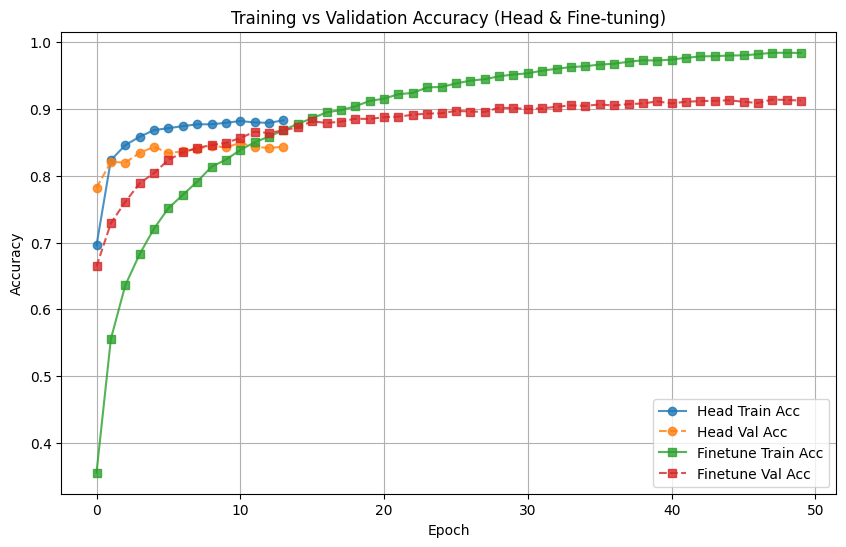

In [10]:
#Cell 10: Training accuracu visioalization

plot_training(history_head, history_finetune)